In [ ]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 50
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# HISTORY DATA FOR SCRP
HISTORY_START_DATE = '2010-01-01'

TEST_START_DATE = '2019-01-01'
TEST_END_DATE = '2020-12-31'

EIIE_MODEL = "trained_eiie/policy_EIIE_2018-12-31_4_2024-11-23 21_51_18.pt"

GRAPH_TITLE = "EIIE Trained 2009-2018, 40 episodes"

# Backtest the results

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]

PORT = TEST_TICKER

df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = PORT).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3024, 8)


# Portfolio Optimization Algorithm

In [96]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df


environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.34737474 0.85636632 0.54964338 0.51373051 0.38475346 0.42295937
 0.33556728 0.25343556 0.30422921 0.26926356 0.28669621 0.27967644
 0.31653185 0.28504842 0.21692903 0.23860167 0.3145108  0.24564113
 0.39002321 0.57311482 0.38207404 0.30637593 0.29537877 0.33857682
 0.2648435  0.29768774 0.22339453 0.19688542 0.20898455 0.21092307
 0.20478488 0.23096106 0.17793534 0.24491243 0.16177534 0.17737638
 0.20513845 0.16009191 0.26105273 0.26461654 0.24277227 0.25730886
 0.18510609 0.19516916 0.23255164 0.22507702 0.30021336 0.30449556
 0.29103655 0.22113901 0.36616164 0.24590092 0.29679398 0.29106187
 0.47862137 0.39771822 0.41120068 0.46705118 0.27993154 0.19488781
 0.22099365 0.2613022  0.21350683 0.21825326 0.17926239 0.17375067
 0.24273006 0.33545005 0.203

In [97]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load(EIIE_MODEL, map_location=torch.device('cpu')))

C:\Users\bencj\AppData\Local\Temp\ipykernel_13908\2633074032.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(EIIE_MODEL, map_location=

<All keys matched successfully>

In [98]:
EIIE_results = {
    "test": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["test"]["value"] = environment._asset_memory["final"]
EIIE_results["test"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["test"]["value"], columns=['eiie_net_worth'])
df_date = pd.DataFrame(EIIE_results["test"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 1781791.75
Final accumulative portfolio value: 1.78179175
Maximum DrawDown: -0.3721911301673396
Sharpe ratio: 0.8481223600938982
Total commission cost: 9354.290318087209


In [99]:
print(df_opt)

     eiie_net_worth       Date
0      1.000000e+06 2019-03-14
1      1.010537e+06 2019-03-15
2      1.014756e+06 2019-03-18
3      1.013869e+06 2019-03-19
4      1.011915e+06 2019-03-20
..              ...        ...
450    1.804090e+06 2020-12-23
451    1.784374e+06 2020-12-24
452    1.776950e+06 2020-12-28
453    1.779032e+06 2020-12-29
454    1.781792e+06 2020-12-30

[455 rows x 2 columns]


In [100]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2019-03-14 00:00:00
2020-12-30 00:00:00


In [101]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

test = data_split(portfolio_norm_df, new_opt_start_str,opt_end)

# DONT NORMALIZE PRICES FOR benchmarks with history
environment_benchmarks = PortfolioOptimizationEnv(
    test,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

# Porfolio Baselines

In [102]:
# CRP 

CRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_crp = DRLStableAgent(env = environment_benchmarks)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_benchmarks)
CRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
CRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["test"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["test"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1485918.625
Final accumulative portfolio value: 1.485918625
Maximum DrawDown: -0.3561145557168601
Sharpe ratio: 0.8485496776573588
Total commission cost: 5976.9070655420655
hit end!
     crp_opt_net_worth       Date
0         1.000000e+06 2019-03-14
1         1.011105e+06 2019-03-15
2         1.013119e+06 2019-03-18
3         1.012544e+06 2019-03-19
4         1.011011e+06 2019-03-20
..                 ...        ...
450       1.454998e+06 2020-12-23
451       1.463047e+06 2020-12-24
452       1.480502e+06 2020-12-28
453       1.489113e+06 2020-12-29
454       1.485919e+06 2020-12-30

[455 rows x 2 columns]


In [103]:
# BAH

BAH_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["test"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1572628.25
Final accumulative portfolio value: 1.57262825
Maximum DrawDown: -0.30393281250496473
Sharpe ratio: 0.9789653071486824
Total commission cost: 0.0
hit end!
     bah_opt_net_worth       Date
0         1.000000e+06 2019-03-14
1         1.011105e+06 2019-03-15
2         1.013094e+06 2019-03-18
3         1.012513e+06 2019-03-19
4         1.010968e+06 2019-03-20
..                 ...        ...
450       1.539773e+06 2020-12-23
451       1.550750e+06 2020-12-24
452       1.578312e+06 2020-12-28
453       1.578293e+06 2020-12-29
454       1.572628e+06 2020-12-30

[455 rows x 2 columns]


In [104]:
# OLMAR

OLMAR_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_olmar = DRLStableAgent(env = environment_benchmarks)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment_benchmarks)
OLMAR_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
OLMAR_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_olmar_opt = pd.DataFrame(OLMAR_results["test"]["value"], columns=['olmar_opt_net_worth'])
df_olmar_date = pd.DataFrame(OLMAR_results["test"]["date"], columns=['Date'])
if len(df_olmar_opt) == len(df_olmar_date):
    df_olmar_opt['Date'] = df_olmar_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_olmar_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_olmar_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_olmar_opt.loc[len(df_olmar_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 560089.3125
Final accumulative portfolio value: 0.5600893125
Maximum DrawDown: -0.7345771089923447
Sharpe ratio: -0.29046227505348615
Total commission cost: 316203.58818990656
hit end!
     olmar_opt_net_worth       Date
0           1.000000e+06 2019-03-14
1           1.011105e+06 2019-03-15
2           1.005149e+06 2019-03-18
3           1.003822e+06 2019-03-19
4           1.002713e+06 2019-03-20
..                   ...        ...
450         5.564799e+05 2020-12-23
451         5.624545e+05 2020-12-24
452         5.585901e+05 2020-12-28
453         5.590036e+05 2020-12-29
454         5.600893e+05 2020-12-30

[455 rows x 2 columns]


In [105]:
# RMR

RMR_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_rmr = DRLStableAgent(env = environment_benchmarks)
model_rmr = agent_rmr.get_model("rmr", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_rmr, environment_benchmarks)
RMR_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
RMR_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_rmr_opt = pd.DataFrame(RMR_results["test"]["value"], columns=['rmr_opt_net_worth'])
df_rmr_date = pd.DataFrame(RMR_results["test"]["date"], columns=['Date'])
if len(df_rmr_opt) == len(df_rmr_date):
    df_rmr_opt['Date'] = df_rmr_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_rmr_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_rmr_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_rmr_opt.loc[len(df_rmr_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 2313898.5
Final accumulative portfolio value: 2.3138985
Maximum DrawDown: -0.31427296211533706
Sharpe ratio: 1.4299276426734915
Total commission cost: 25095.76933006686
hit end!
     rmr_opt_net_worth       Date
0         1.000000e+06 2019-03-14
1         1.011105e+06 2019-03-15
2         1.005149e+06 2019-03-18
3         1.003822e+06 2019-03-19
4         1.002713e+06 2019-03-20
..                 ...        ...
450       2.266140e+06 2020-12-23
451       2.283616e+06 2020-12-24
452       2.365292e+06 2020-12-28
453       2.333798e+06 2020-12-29
454       2.313898e+06 2020-12-30

[455 rows x 2 columns]


In [106]:
# BNN

BNN_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bnn = DRLStableAgent(env = environment_benchmarks)
model_bnn = agent_bnn.get_model("bnn", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_bnn, environment_benchmarks)
BNN_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BNN_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bnn_opt = pd.DataFrame(BNN_results["test"]["value"], columns=['bnn_opt_net_worth'])
df_bnn_date = pd.DataFrame(BNN_results["test"]["date"], columns=['Date'])
if len(df_bnn_opt) == len(df_bnn_date):
    df_bnn_opt['Date'] = df_bnn_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bnn_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bnn_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bnn_opt.loc[len(df_bnn_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 808190.0
Final accumulative portfolio value: 0.80819
Maximum DrawDown: -0.7549295353104509
Sharpe ratio: 0.06838989194433955
Total commission cost: 220460.89739674982
hit end!
     bnn_opt_net_worth       Date
0          1000000.000 2019-03-14
1          1000000.000 2019-03-15
2          1000000.000 2019-03-18
3          1000000.000 2019-03-19
4          1000000.000 2019-03-20
..                 ...        ...
450         779624.000 2020-12-23
451         787994.375 2020-12-24
452         785226.250 2020-12-28
453         813062.750 2020-12-29
454         808190.000 2020-12-30

[455 rows x 2 columns]


In [107]:
# SCRP

# Download the history data for scrp

history_df = YahooDownloader(start_date = HISTORY_START_DATE,
                     end_date = opt_start_date,
                     ticker_list = PORT).fetch_data()

# Dont normalize the price data here

SCRP_results = {
    "test": {},
}

history_df_environment = PortfolioOptimizationEnv(
        history_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close"],
        normalize_df=None
    )

# Pull out the historical price data for SCRP over the training period
agent_history_scrp = DRLStableAgent(env = history_df_environment)
history_scrp = agent_history_scrp.get_model("scrp")

_, _ = DRLStableAgent.DRL_prediction(history_scrp, history_df_environment)


# now make the predictions with the historical price data, but in the test period only
SCRP_model_kwargs = {
    "price_history": history_scrp.price_history
}

print(history_scrp.price_history)

environment_benchmarks.reset()
agent_scrp = DRLStableAgent(env = environment_benchmarks)
model_scrp = agent_scrp.get_model("scrp", model_kwargs=SCRP_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_scrp, environment_benchmarks)
SCRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
SCRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_scrp_opt = pd.DataFrame(SCRP_results["test"]["value"], columns=['scrp_opt_net_worth'])
df_scrp_date = pd.DataFrame(SCRP_results["test"]["date"], columns=['Date'])
if len(df_scrp_opt) == len(df_scrp_date):
    df_scrp_opt['Date'] = df_scrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_scrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_scrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_scrp_opt.loc[len(df_scrp_opt)-1,'Date']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Shape of DataFrame:  (13878, 8)
Initial portfolio value:1000000
Final portfolio value: 4080856.5
Final accumulative portfolio value: 4.0808565
Maximum DrawDown: -0.4270597178612635
Sharpe ratio: 0.7601920113610432
Total commission cost: 208719.8037472627
hit end!
              0           1          2           3           4          5
0      6.447412   43.777546  13.519426   23.300680   19.785192  13.113413
1      6.458560   45.211338  13.512954   23.308205   19.558470  12.982836
2      6.355828   46.582798  13.467627   23.165165   19.295834  12.953823
3      6.344078   48.468563  13.338132   22.924253   19.475416  12.961070
4      6.386255   48.001015  13.487050   23.082354   19.529289  12.895780
...         ...         ...        ...         ...         ...        ...
2308  41.366711  412.662994  45.555607  104.492325  141.076508  29.603941
2309  41.465015  412.643463  45.451687  104.605919  141.576126  29.646469
2310  42.901470  390.641144  46.205181  106.801956  144.766037  29.916

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 2169200.25
Final accumulative portfolio value: 2.16920025
Maximum DrawDown: -0.25118255106008813
Sharpe ratio: 1.4968069371465227
Total commission cost: 15151.898523109034
hit end!
     scrp_opt_net_worth       Date
0          1.000000e+06 2019-03-14
1          1.012467e+06 2019-03-15
2          1.016954e+06 2019-03-18
3          1.014124e+06 2019-03-19
4          1.013297e+06 2019-03-20
..                  ...        ...
450        2.128725e+06 2020-12-23
451        2.143444e+06 2020-12-24
452        2.213142e+06 2020-12-28
453        2.185639e+06 2020-12-29
454        2.169200e+06 2020-12-30

[455 rows x 2 columns]


# Try BCRP extreme, which is the absolute best portfolio over the period with hindsight


In [108]:
# bcrp

BCRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bcrp= DRLStableAgent(env = environment_benchmarks)
model_bcrp= agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_benchmarks)
BCRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BCRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bcrp_opt = pd.DataFrame(BCRP_results["test"]["value"], columns=['bcrp_opt_net_worth'])
df_bcrp_date = pd.DataFrame(BCRP_results["test"]["date"], columns=['Date'])
if len(df_bcrp_opt) == len(df_bcrp_date):
    df_bcrp_opt['Date'] = df_bcrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bcrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bcrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bcrp_opt.loc[len(df_bcrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 2967759.0
Final accumulative portfolio value: 2.967759
Maximum DrawDown: -0.3142728493500595
Sharpe ratio: 1.7711970644574735
Total commission cost: 0.0
hit end!
     bcrp_opt_net_worth       Date
0          1.000000e+06 2019-03-14
1          1.013008e+06 2019-03-15
2          1.023349e+06 2019-03-18
3          1.015240e+06 2019-03-19
4          1.024112e+06 2019-03-20
..                  ...        ...
450        2.906504e+06 2020-12-23
451        2.928919e+06 2020-12-24
452        3.033675e+06 2020-12-28
453        2.993282e+06 2020-12-29
454        2.967759e+06 2020-12-30

[455 rows x 2 columns]


# Stock environment optimization algorithm

In [109]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (454, 8)
Annual return          0.096183
Cumulative returns     0.179920
Annual volatility      0.285733
Sharpe ratio           0.466041
Calmar ratio           0.259349
Stability              0.058086
Max drawdown          -0.370862
Omega ratio            1.108194
Sortino ratio          0.638874
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.829211
Daily value at risk   -0.035471
dtype: float64
df_dji:            date           dji
0   2019-03-14  1.000000e+06
1   2019-03-15  1.005404e+06
2   2019-03-18  1.007941e+06
3   2019-03-19  1.006902e+06
4   2019-03-20  1.001390e+06
..         ...           ...
450 2020-12-23  1.171914e+06
451 2020-12-24  1.174638e+06
452 2020-12-28  1.182577e+06
453 2020-12-29  1.179920e+06
454 2020-12-30           NaN

[455 rows x 2 columns]
df_dji:                       dji
date                    
2019-03-14  1.000000e+06
2019-03-15  1.005404e+06
2019-03-18  1.007941e+06
2019-03-19  1.006902e+06

# Compare all results

In [110]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')


# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt

# Merge the baseline BCRP algorithm
df_bcrp_opt['Date'] = pd.to_datetime(df_bcrp_opt['Date'])
merged_df = pd.merge(merged_df, df_bcrp_opt, on='Date')

# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge the baseline OLMAR algorithm
df_olmar_opt['Date'] = pd.to_datetime(df_olmar_opt['Date'])
merged_df = pd.merge(merged_df, df_olmar_opt, on='Date')

# Merge the baseline RMR algorithm
df_rmr_opt['Date'] = pd.to_datetime(df_rmr_opt['Date'])
merged_df = pd.merge(merged_df, df_rmr_opt, on='Date')

# Merge the baseline BNN algorithm
df_bnn_opt['Date'] = pd.to_datetime(df_bnn_opt['Date'])
merged_df = pd.merge(merged_df, df_bnn_opt, on='Date')

# Merge the baseline SCRP algorithm
df_scrp_opt['Date'] = pd.to_datetime(df_scrp_opt['Date'])
merged_df = pd.merge(merged_df, df_scrp_opt, on='Date')

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')



print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2019-03-14  1.000000e+06
2019-03-15  1.005404e+06
2019-03-18  1.007941e+06
2019-03-19  1.006902e+06
2019-03-20  1.001390e+06
...                  ...
2020-12-23  1.171914e+06
2020-12-24  1.174638e+06
2020-12-28  1.182577e+06
2020-12-29  1.179920e+06
2020-12-30           NaN

[455 rows x 1 columns]
     crp_opt_net_worth       Date  bcrp_opt_net_worth  bah_opt_net_worth  \
0         1.000000e+06 2019-03-14        1.000000e+06       1.000000e+06   
1         1.011105e+06 2019-03-15        1.013008e+06       1.011105e+06   
2         1.013119e+06 2019-03-18        1.023349e+06       1.013094e+06   
3         1.012544e+06 2019-03-19        1.015240e+06       1.012513e+06   
4         1.011011e+06 2019-03-20        1.024112e+06       1.010968e+06   
..                 ...        ...                 ...                ...   
450       1.454998e+06 2020-12-23        2.906504e+06       1.539773e+06   
451       1.463047e+06 2020-12-24        2.

# Baseline CRP in the environment

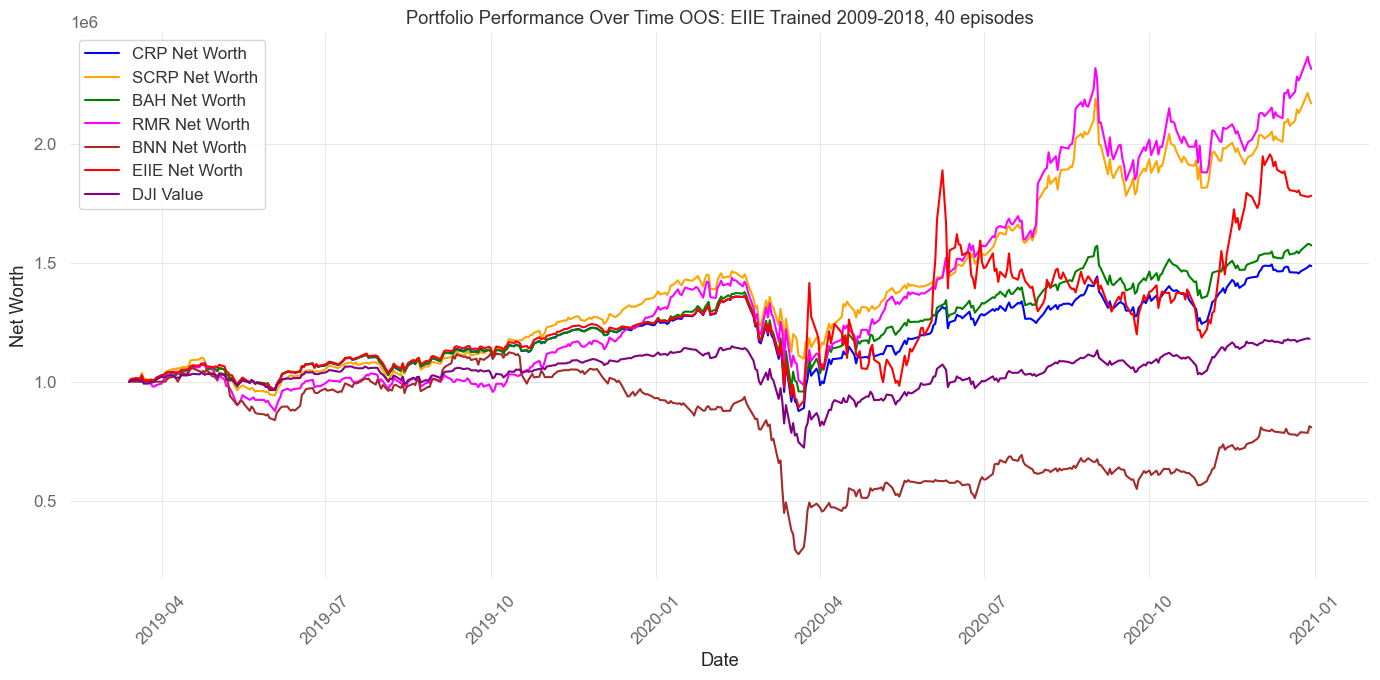

In [111]:
# Use the correct backend for Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

# TODO make sure all dates line up, fix CRP and OLMAR 

import matplotlib.pyplot as plt

# Define a color map for the labels
color_map = {
    'CRP Net Worth': 'blue',
    'BAH Net Worth': 'green',
    'EIIE Net Worth': 'red',
    'DJI Value': 'purple',
    'SCRP Net Worth': 'orange',
    'OLMAR Net Worth': 'cyan',
    'RMR Net Worth': 'magenta',
    'BNN Net Worth': 'brown'
}




plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP Net Worth', color=color_map['CRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['scrp_opt_net_worth'], label='SCRP Net Worth', color=color_map['SCRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH Net Worth', color=color_map['BAH Net Worth'])
# plt.plot(merged_df['Date'], merged_df['olmar_opt_net_worth'], label='OLMAR Net Worth', color=color_map['OLMAR Net Worth'])
plt.plot(merged_df['Date'], merged_df['rmr_opt_net_worth'], label='RMR Net Worth', color=color_map['RMR Net Worth'])
plt.plot(merged_df['Date'], merged_df['bnn_opt_net_worth'], label='BNN Net Worth', color=color_map['BNN Net Worth'])
plt.plot(merged_df['Date'], merged_df['eiie_net_worth'], label='EIIE Net Worth', color=color_map['EIIE Net Worth'])
plt.plot(merged_df['Date'], merged_df['dji'], label='DJI Value', color=color_map['DJI Value'])
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time OOS: ' + GRAPH_TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [112]:
import pprint

final_returns = {
   'BCRP OPT': merged_df['bcrp_opt_net_worth'].iloc[-1],
    'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
    'SCRP': merged_df['scrp_opt_net_worth'].iloc[-1],
    'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
    'OLMAR': merged_df['olmar_opt_net_worth'].iloc[-1],
    'RMR': merged_df['rmr_opt_net_worth'].iloc[-1],
    'BNN': merged_df['bnn_opt_net_worth'].iloc[-1],
    'EIIE': merged_df['eiie_net_worth'].iloc[-1],
}

pprint.pprint(final_returns)

{'BAH': 1572628.25,
 'BCRP OPT': 2967759.0,
 'BNN': 808190.0,
 'CRP': 1485918.625,
 'EIIE': 1781791.75,
 'OLMAR': 560089.3125,
 'RMR': 2313898.5,
 'SCRP': 2169200.25}


In [113]:
import numpy as np
import pprint

# Calculate the returns each day

# merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
# merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['BCRP_opt_daily_return'] = merged_df['bcrp_opt_net_worth'].pct_change()
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['SCRP_opt_daily_return'] = merged_df['scrp_opt_net_worth'].pct_change()

merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['OLMAR_opt_daily_return'] = merged_df['olmar_opt_net_worth'].pct_change()
merged_df['RMR_opt_daily_return'] = merged_df['rmr_opt_net_worth'].pct_change()
merged_df['BNN_opt_daily_return'] = merged_df['bnn_opt_net_worth'].pct_change()

merged_df['EIIE_daily_return'] = merged_df['eiie_net_worth'].pct_change()


# merged_df['OLMAR_daily_return'] = merged_df['OLMAR_net_worth'].pct_change()


# TODO need to put in the fama french

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    # 'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    # 'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'BCRP': calculate_sharpe_ratio(merged_df['BCRP_opt_daily_return'], risk_free_rate),
    'CRP': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'], risk_free_rate),
    'SCRP': calculate_sharpe_ratio(merged_df['SCRP_opt_daily_return'], risk_free_rate),
    'BAH': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_opt_daily_return'], risk_free_rate),
    'RMR': calculate_sharpe_ratio(merged_df['RMR_opt_daily_return'], risk_free_rate),
    'BNN': calculate_sharpe_ratio(merged_df['BNN_opt_daily_return'], risk_free_rate),
    'EIIE': calculate_sharpe_ratio(merged_df['EIIE_daily_return'], risk_free_rate),
    # 'OLMAR old': calculate_sharpe_ratio(merged_df['OLMAR_daily_return'], risk_free_rate),
    # 'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),

}

pprint.pprint(sharpe_ratios)

{'BAH': 0.914238324996795,
 'BCRP': 1.7208172308639422,
 'BNN': 0.03256575497631269,
 'CRP': 0.786867643932423,
 'EIIE': 0.8130288771205618,
 'OLMAR': -0.3267247965335313,
 'RMR': 1.3781135522517938,
 'SCRP': 1.4362750667193445}


In [114]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    # 'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    # 'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'BCRP': max_drawdown(merged_df['bcrp_opt_net_worth']),
    'CRP': max_drawdown(merged_df['crp_opt_net_worth']),
    'SCRP': max_drawdown(merged_df['scrp_opt_net_worth']),
    'BAH': max_drawdown(merged_df['bah_opt_net_worth']),
    'OLMAR': max_drawdown(merged_df['olmar_opt_net_worth']),
    'RMR': max_drawdown(merged_df['rmr_opt_net_worth']),
    'BNN': max_drawdown(merged_df['bnn_opt_net_worth']),
    'EIIE': max_drawdown(merged_df['eiie_net_worth']),
    # 'Opt': max_drawdown(merged_df['opt_net_worth']),
}

pprint.pprint(max_drawdowns)


{'BAH': -0.30393281250496473,
 'BCRP': -0.3142728493500595,
 'BNN': -0.7549295353104509,
 'CRP': -0.3561145557168601,
 'EIIE': -0.3721911301673396,
 'OLMAR': -0.7345771089923447,
 'RMR': -0.31427296211533706,
 'SCRP': -0.25118255106008813}


In [115]:
import numpy as np
import pandas as pd

# Define a function to calculate the ratio of up days
def calculate_up_days_ratio(series):
    up_days = (series > 0).sum()
    total_days = series.count()
    return up_days / total_days if total_days > 0 else 0

# Calculate the ratio of up days for each daily return column
up_days_ratios = {
    'BCRP': calculate_up_days_ratio(merged_df['BCRP_opt_daily_return']),
    'CRP': calculate_up_days_ratio(merged_df['CRP_opt_daily_return']),
    'SCRP': calculate_up_days_ratio(merged_df['SCRP_opt_daily_return']),
    'BAH': calculate_up_days_ratio(merged_df['BAH_opt_daily_return']),
    'OLMAR': calculate_up_days_ratio(merged_df['OLMAR_opt_daily_return']),
    'RMR': calculate_up_days_ratio(merged_df['RMR_opt_daily_return']),
    'BNN': calculate_up_days_ratio(merged_df['BNN_opt_daily_return']),
    'EIIE': calculate_up_days_ratio(merged_df['EIIE_daily_return']),
}

pprint.pprint(up_days_ratios)




{'BAH': 0.6057268722466961,
 'BCRP': 0.552863436123348,
 'BNN': 0.47577092511013214,
 'CRP': 0.5748898678414097,
 'EIIE': 0.5418502202643172,
 'OLMAR': 0.5022026431718062,
 'RMR': 0.552863436123348,
 'SCRP': 0.566079295154185}


In [116]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['EIIE_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


             sum_sq     df         F    PR(>F)
Portfolio  0.000108    1.0  0.135361  0.713023
Residual   0.719996  906.0       NaN       NaN


In [117]:
from scipy import stats

df_ppo = merged_df['EIIE_daily_return'].dropna() 
df_bah = merged_df['BAH_opt_daily_return'].dropna()

print(df_bah)

t_stat, p_value = stats.ttest_ind(df_ppo, df_bah) 

print(f"t-statistic: {t_stat}") 
print(f"p-value: {p_value}")

1      0.011105
2      0.001967
3     -0.000573
4     -0.001525
5      0.014001
         ...   
450   -0.005379
451    0.007129
452    0.017773
453   -0.000012
454   -0.003589
Name: BAH_opt_daily_return, Length: 454, dtype: float64
t-statistic: 0.3679144212596018
p-value: 0.7130229821815514
